In [1]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pprint import pprint
import pandas as pd

In [2]:
# Import LeRobot modules
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from lerobot.policies.factory import make_policy

c:\Users\19142\.conda\envs\my_robotics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set plot style for academic report (IEEE style)
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "figure.figsize": (8, 5),
    "figure.dpi": 300
})

## 1. Exploratory Data Analysis (EDA)
 
Goal: Understand the distribution of the robot's action space (joint angles).
This helps in explaining the dataset characteristics in the "Method" section.

In [5]:
# Configuration
DATASET_ID = "lerobot/svla_so100_pickplace"
# Use a subset of episodes for faster analysis if the dataset is huge
EPISODES_TO_ANALYZE = range(0, 50) 

print(f"Loading dataset: {DATASET_ID}...")
dataset = LeRobotDataset(DATASET_ID, episodes=EPISODES_TO_ANALYZE)
print(f"Loaded {len(dataset)} frames from {len(dataset.episodes)} episodes.")

Loading dataset: lerobot/svla_so100_pickplace...


Loaded 19631 frames from 50 episodes.


In [10]:
from tqdm import tqdm
# Extract all actions from the loaded dataset
# We iterate through the dataset to collect the 'action' tensor (Joint Positions)
all_actions = []

print("Extracting actions for analysis...")
# Note: This might take a minute depending on dataset size
for i in tqdm(range(len(dataset)), desc="Extracting actions"):
    item = dataset[i]
    all_actions.append(item['action'].numpy())

all_actions = np.array(all_actions)
print(f"Action array shape: {all_actions.shape}") 
# Expected shape: (N_frames, 6) for SO-100 (5 joints + 1 gripper) or (N, 7) depending on config

Extracting actions for analysis...


Extracting actions:   0%|          | 0/19631 [00:00<?, ?it/s]c:\Users\19142\.conda\envs\my_robotics\lib\site-packages\torchvision\io\_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
Extracting actions: 100%|██████████| 19631/19631 [18:34<00:00, 17.61it/s]


Action array shape: (19631, 6)


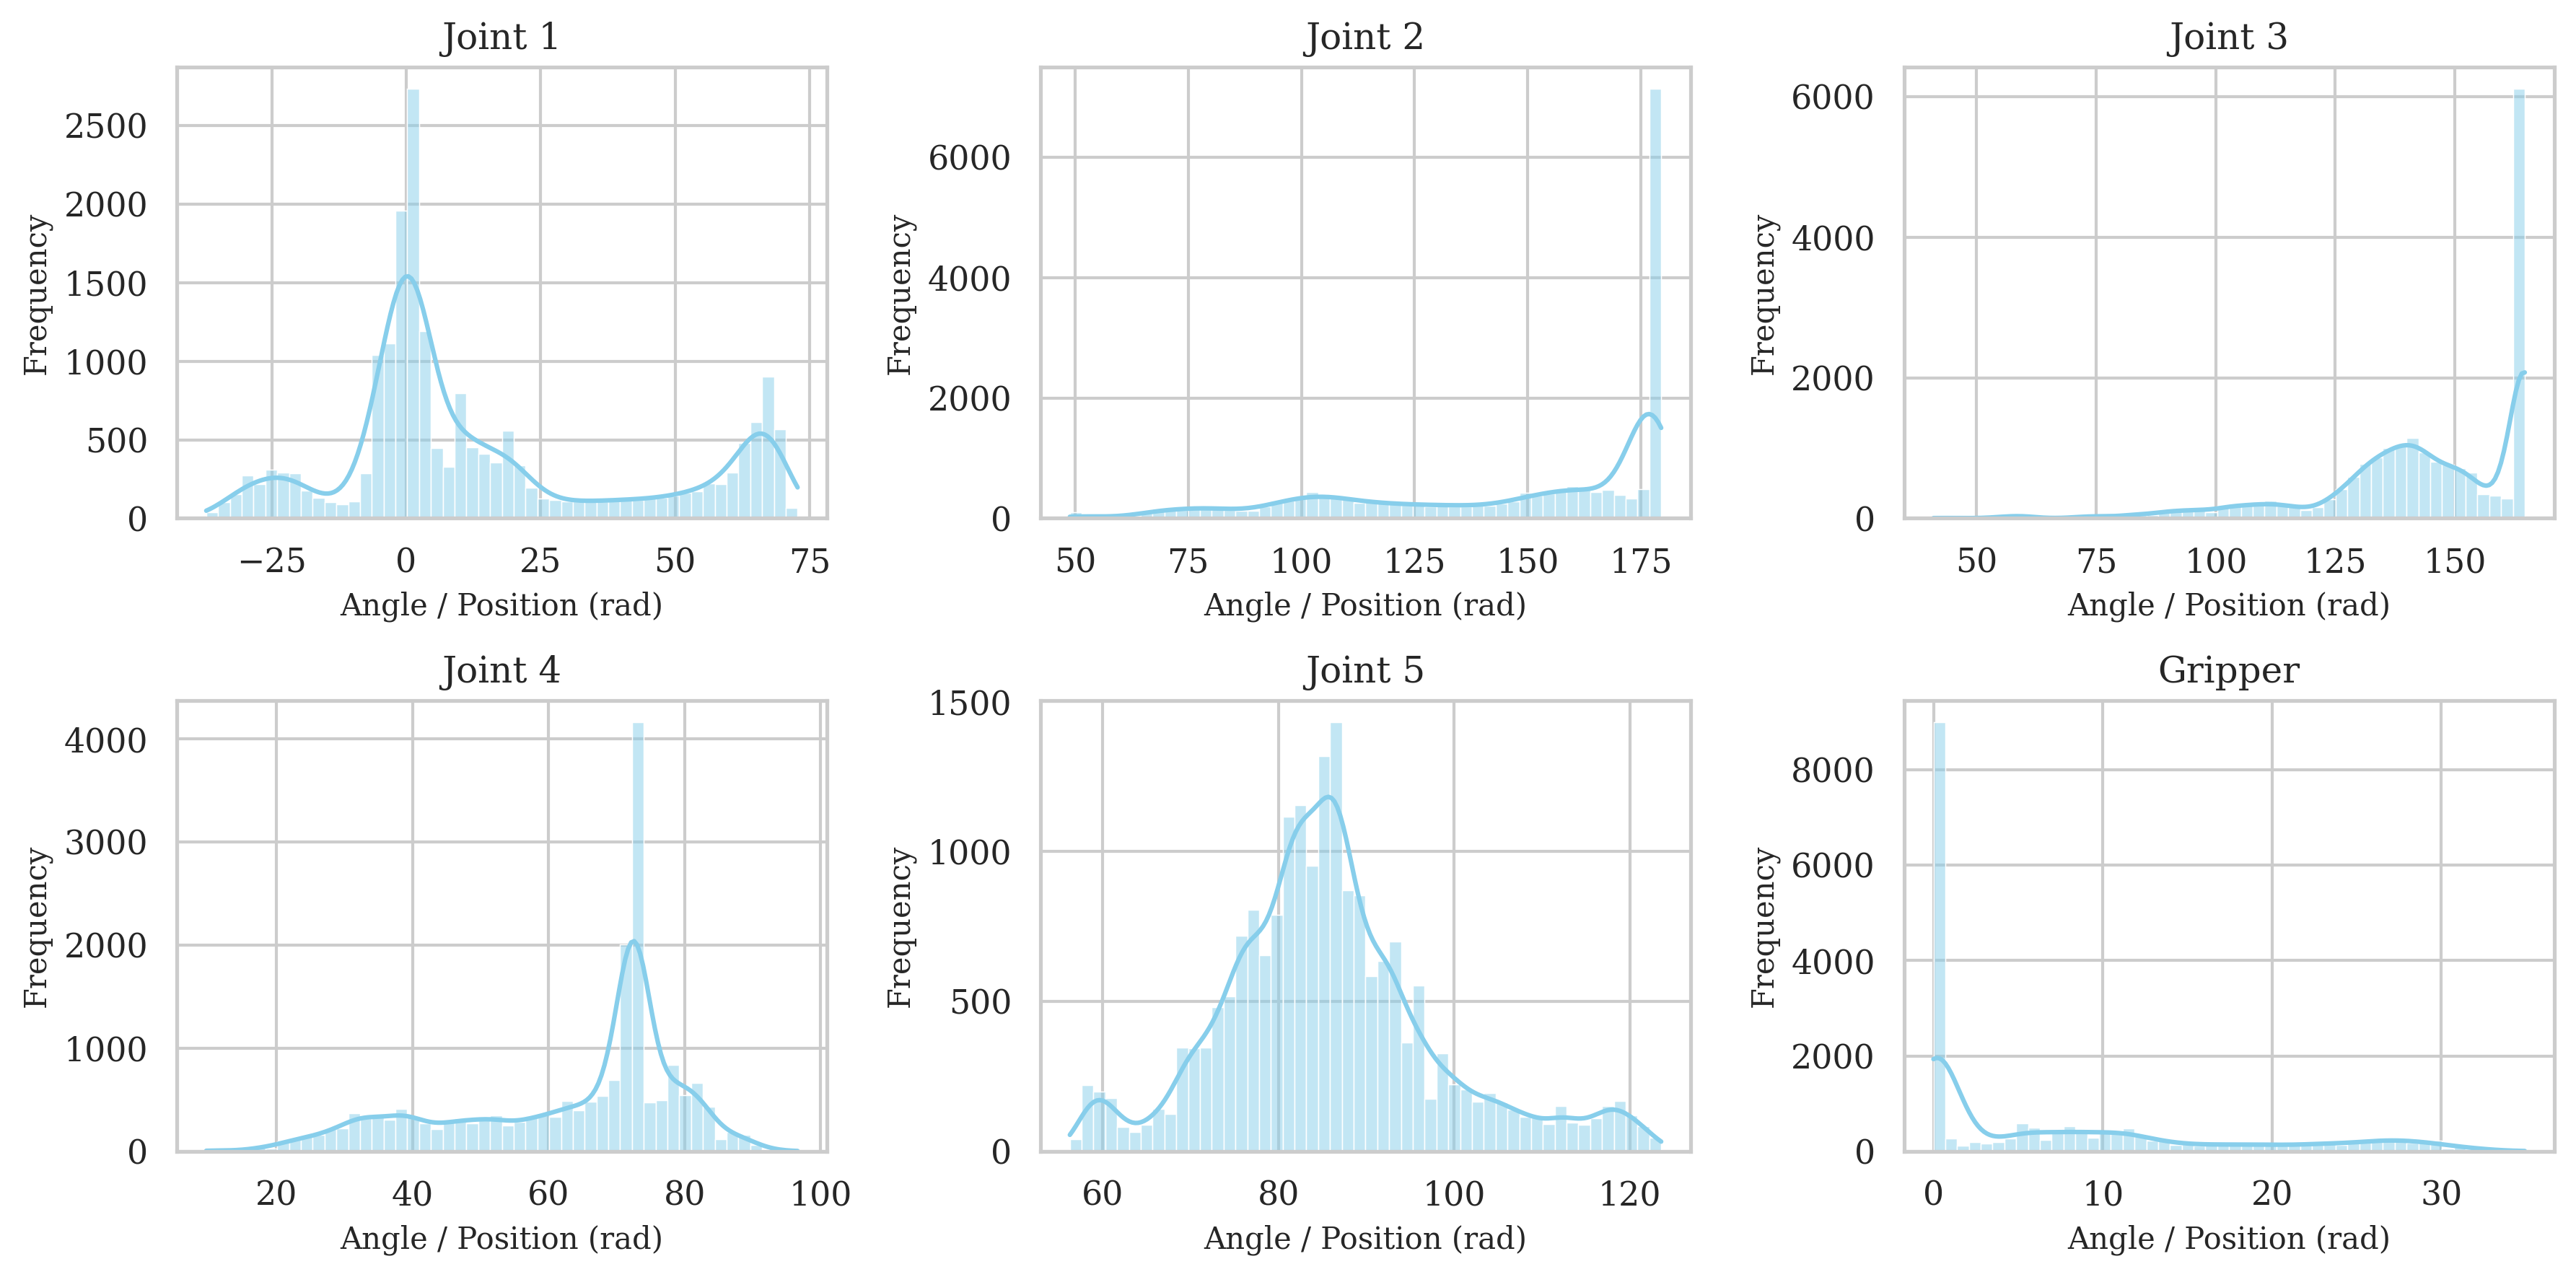

Figure saved to outputs/action_distribution.png


In [31]:
# Visualization 1: Joint Value Distributions (Histograms)
# This figure shows the range of motion for each motor.

num_joints = all_actions.shape[1]
fig, axes = plt.subplots(2, 3, figsize=(12, 6)) # Adjust grid based on num_joints (e.g. 2x3 for 6 joints)
axes = axes.flatten()

joint_names = [f"Joint {i+1}" for i in range(num_joints)]
# Rename the last one to "Gripper" if applicable for SO-100
if num_joints == 6:
    joint_names[-1] = "Gripper"

for i, ax in enumerate(axes):
    if i < num_joints:
        sns.histplot(all_actions[:, i], bins=50, kde=True, ax=ax, color='skyblue')
        ax.set_title(joint_names[i])
        ax.set_xlabel("Angle / Position (rad)")
        ax.set_ylabel("Frequency")
    else:
        ax.axis('off') # Hide unused subplots

plt.tight_layout()
plt.savefig("../outputs/action_distribution.png", bbox_inches='tight')
plt.show()
print("Figure saved to outputs/action_distribution.png")

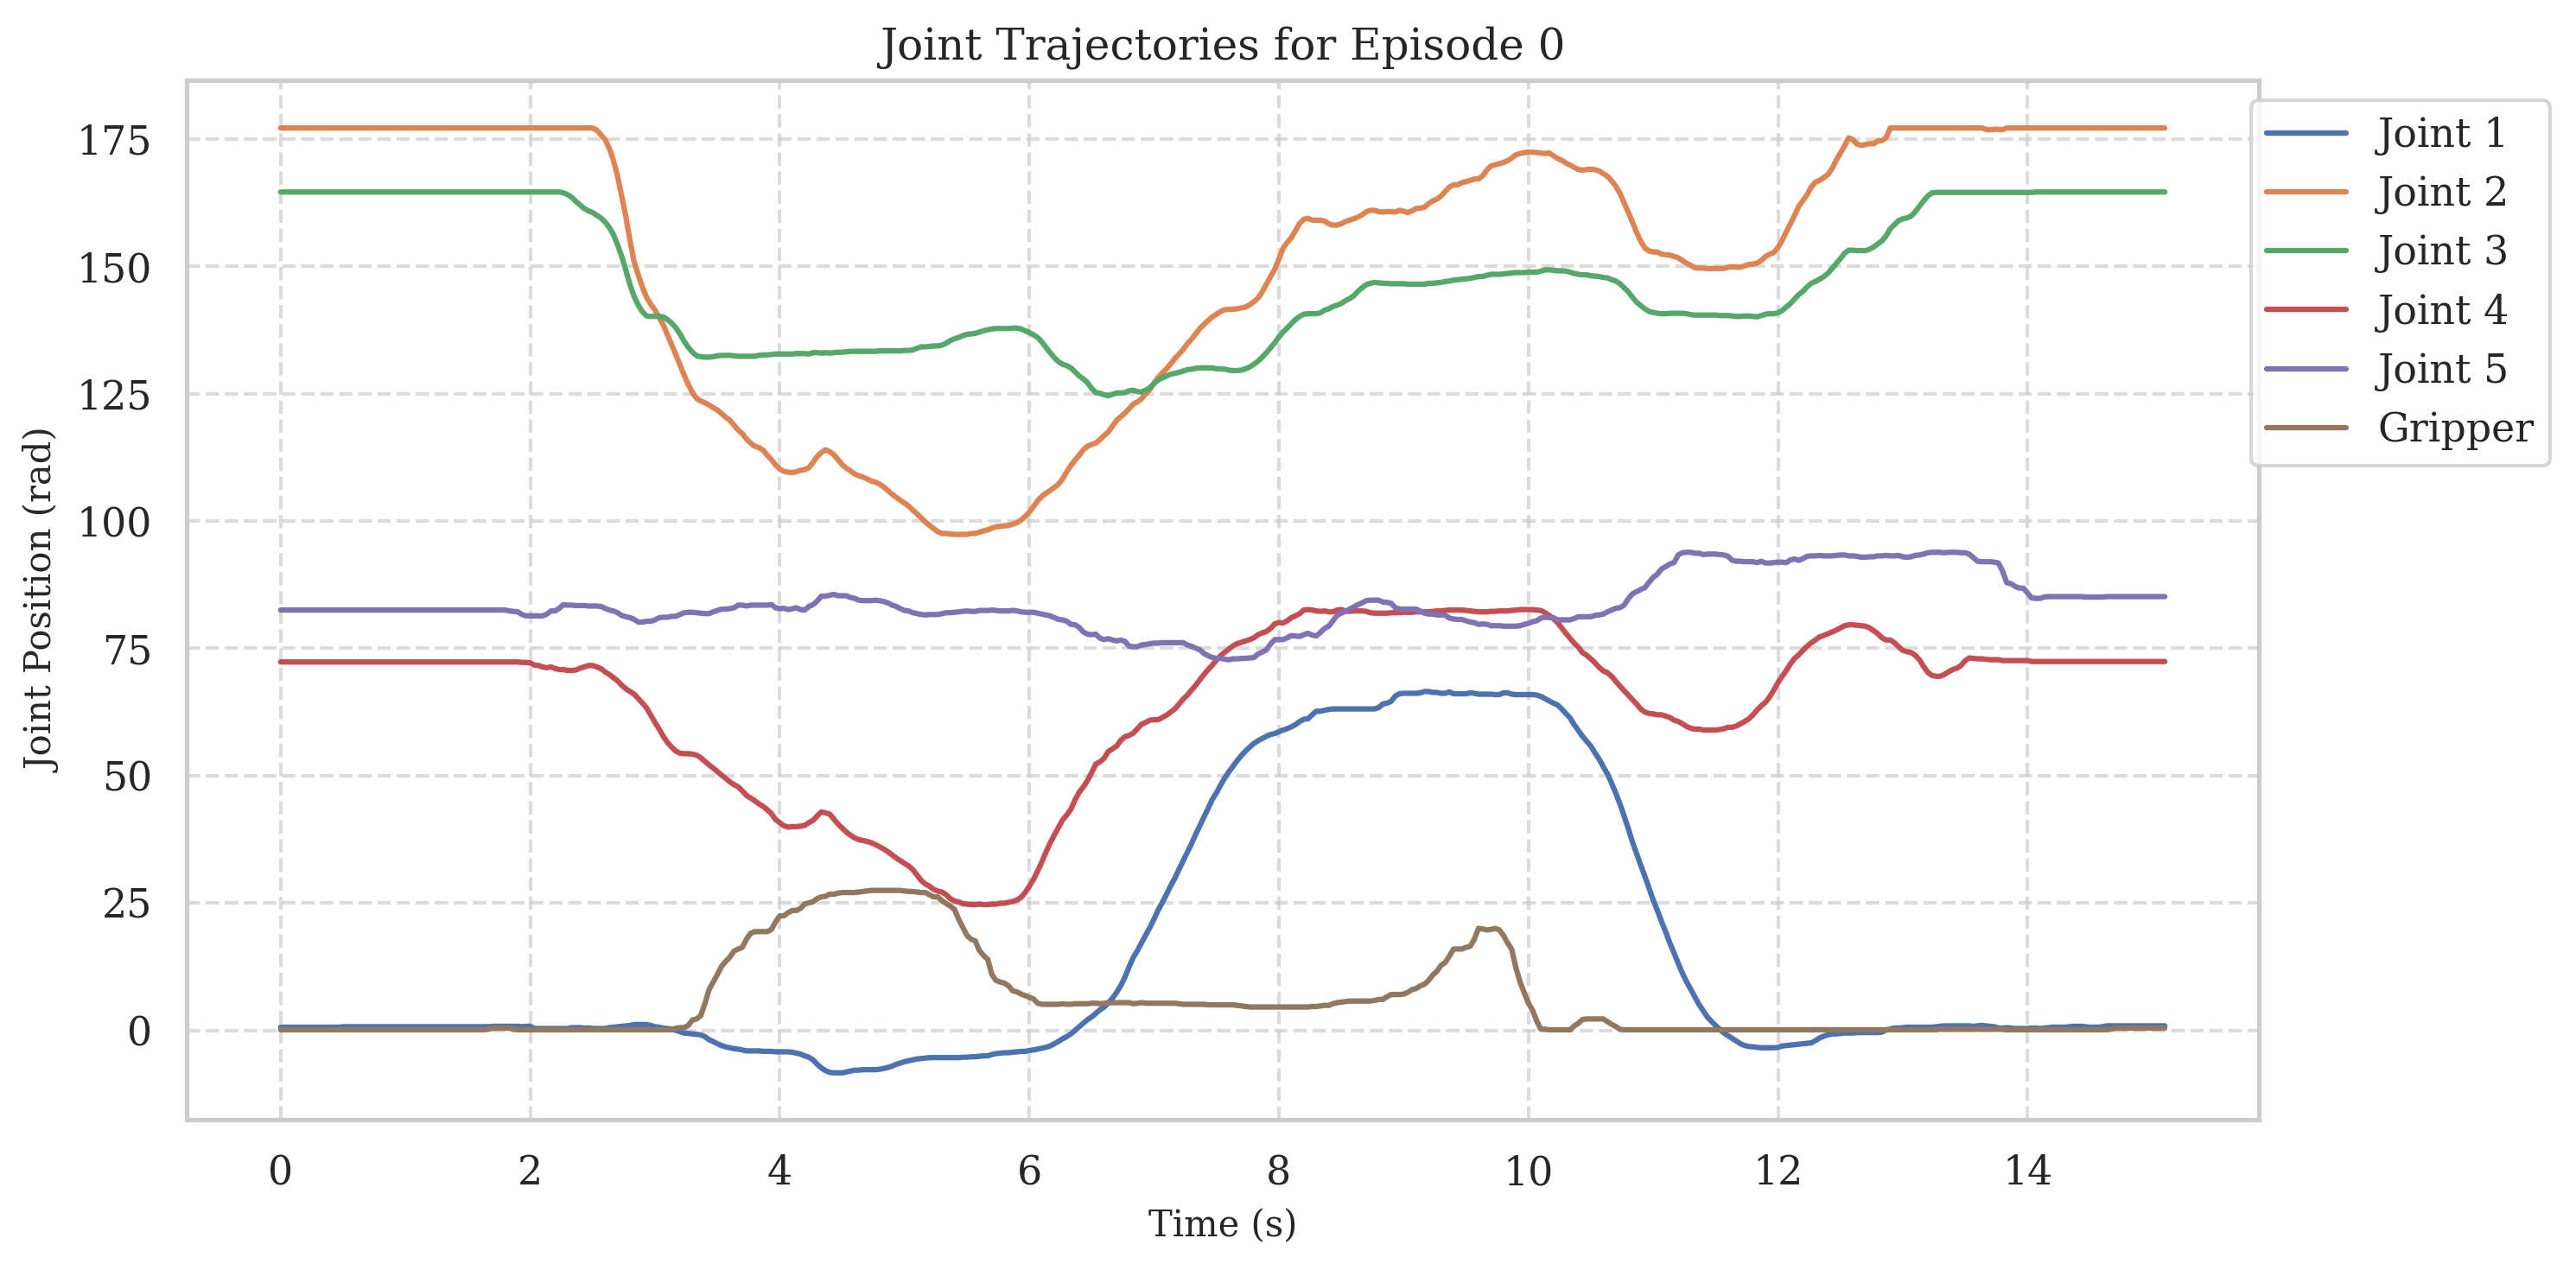

In [21]:
# Visualization 2: Single Episode Trajectory
# This shows how joints move over time in a single demonstration.

episode_idx = 0
# Get indices for the first episode
episode_meta = dataset.meta.episodes[episode_idx]
start_idx = episode_meta["dataset_from_index"]
end_idx = episode_meta["dataset_to_index"]

episode_actions = all_actions[start_idx:end_idx]
time_steps = np.arange(len(episode_actions)) / dataset.fps # Convert frame to seconds

plt.figure(figsize=(10, 5))
for i in range(num_joints):
    plt.plot(time_steps, episode_actions[:, i], label=joint_names[i], linewidth=1.5)

plt.title(f"Joint Trajectories for Episode {episode_idx}")
plt.xlabel("Time (s)")
plt.ylabel("Joint Position (rad)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../outputs/single_episode_trajectory.png", bbox_inches='tight')
plt.show()

In [22]:
repo_id = "lerobot/svla_so100_pickplace"
dataset = LeRobotDataset(repo_id)

# loading dataset
print(f"=== Dataset Metadata for {repo_id} ===")
print(f"Total Episodes: {dataset.meta.total_episodes}")
print(f"Total Frames: {dataset.meta.total_frames}")
print(f"FPS: {dataset.fps}")
print(f"Robot Type: {dataset.meta.robot_type}")
print(f"Features: {list(dataset.features.keys())}")

# check prompt
tasks = dataset.meta.tasks
print(f"\nUnique Tasks ({len(tasks)}):")
print(tasks.head())

=== Dataset Metadata for lerobot/svla_so100_pickplace ===
Total Episodes: 50
Total Frames: 19631
FPS: 30
Robot Type: so100
Features: ['action', 'observation.state', 'observation.images.top', 'observation.images.wrist', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']

Unique Tasks (1):
                                           task_index
Pick up the cube and place it in the box.           0


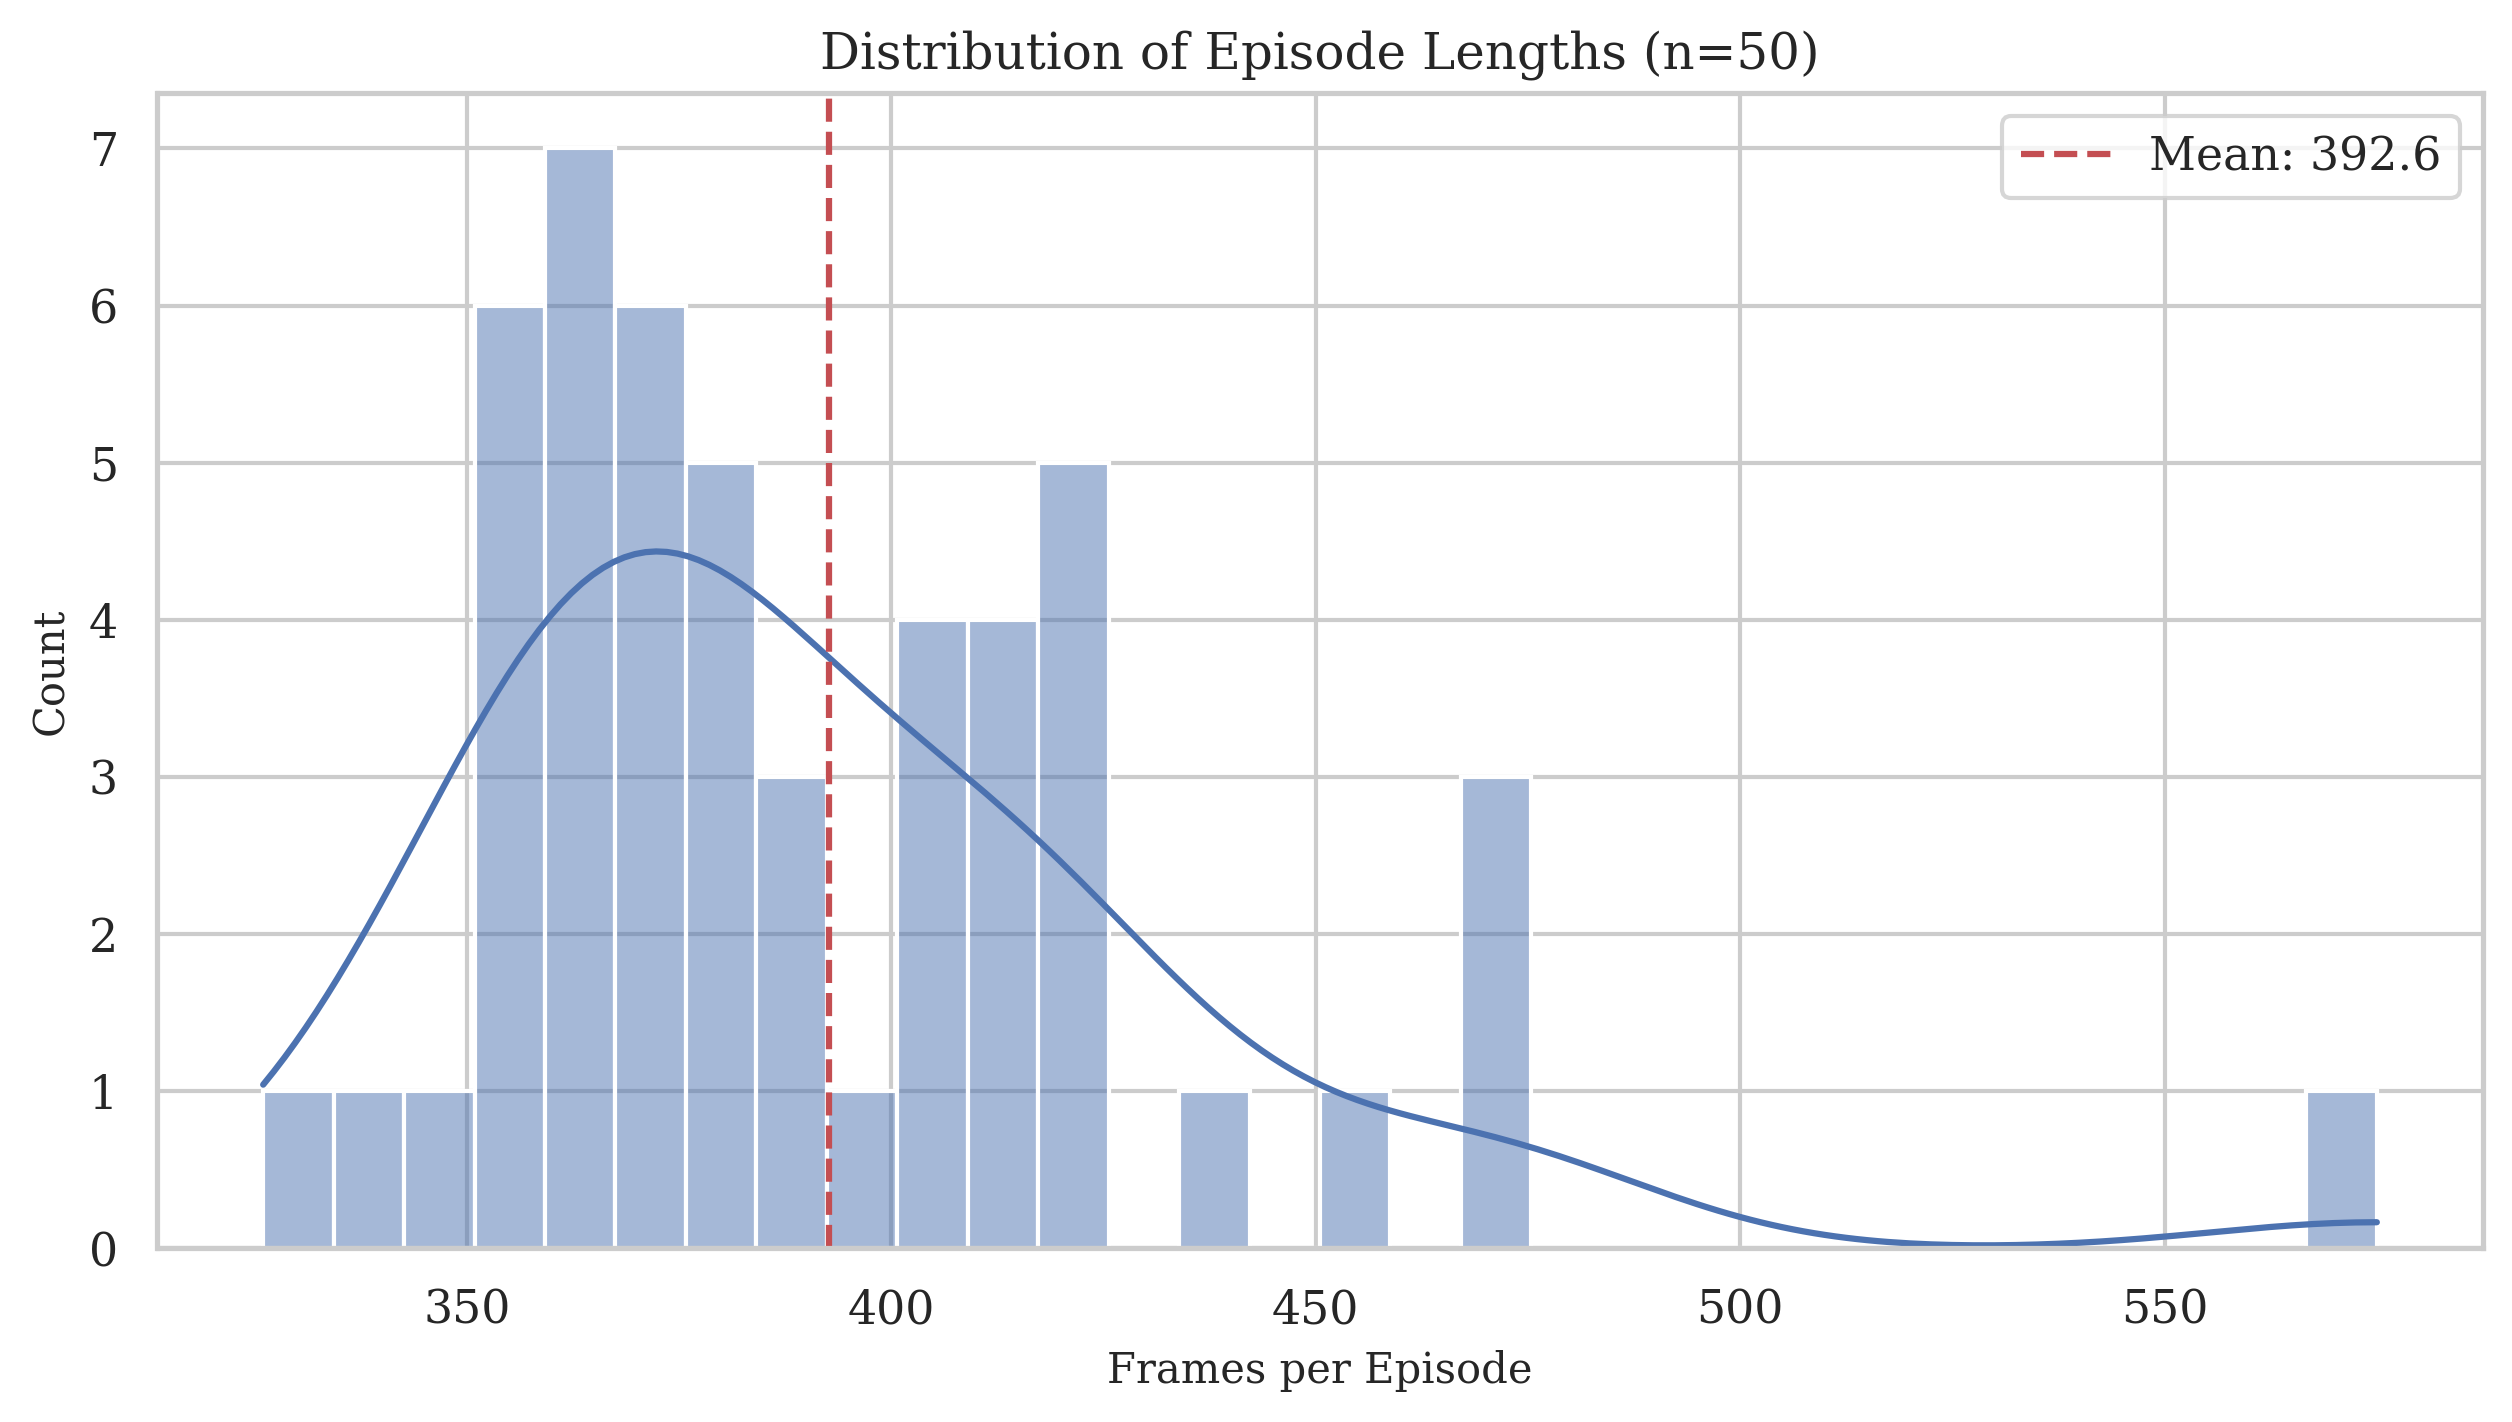

In [7]:
# get the lengths of every episode
episode_lengths = []
for i in range(dataset.meta.total_episodes):
    # dataset.meta.episodes 
    ep_meta = dataset.meta.episodes[i]
    length = ep_meta['length']
    episode_lengths.append(length)

plt.figure(figsize=(10, 5))
sns.histplot(episode_lengths, kde=True, bins=30)
plt.title(f"Distribution of Episode Lengths (n={len(episode_lengths)})")
plt.xlabel("Frames per Episode")
plt.ylabel("Count")
plt.axvline(x=sum(episode_lengths)/len(episode_lengths), color='r', linestyle='--', label=f'Mean: {sum(episode_lengths)/len(episode_lengths):.1f}')
plt.legend()
plt.show()

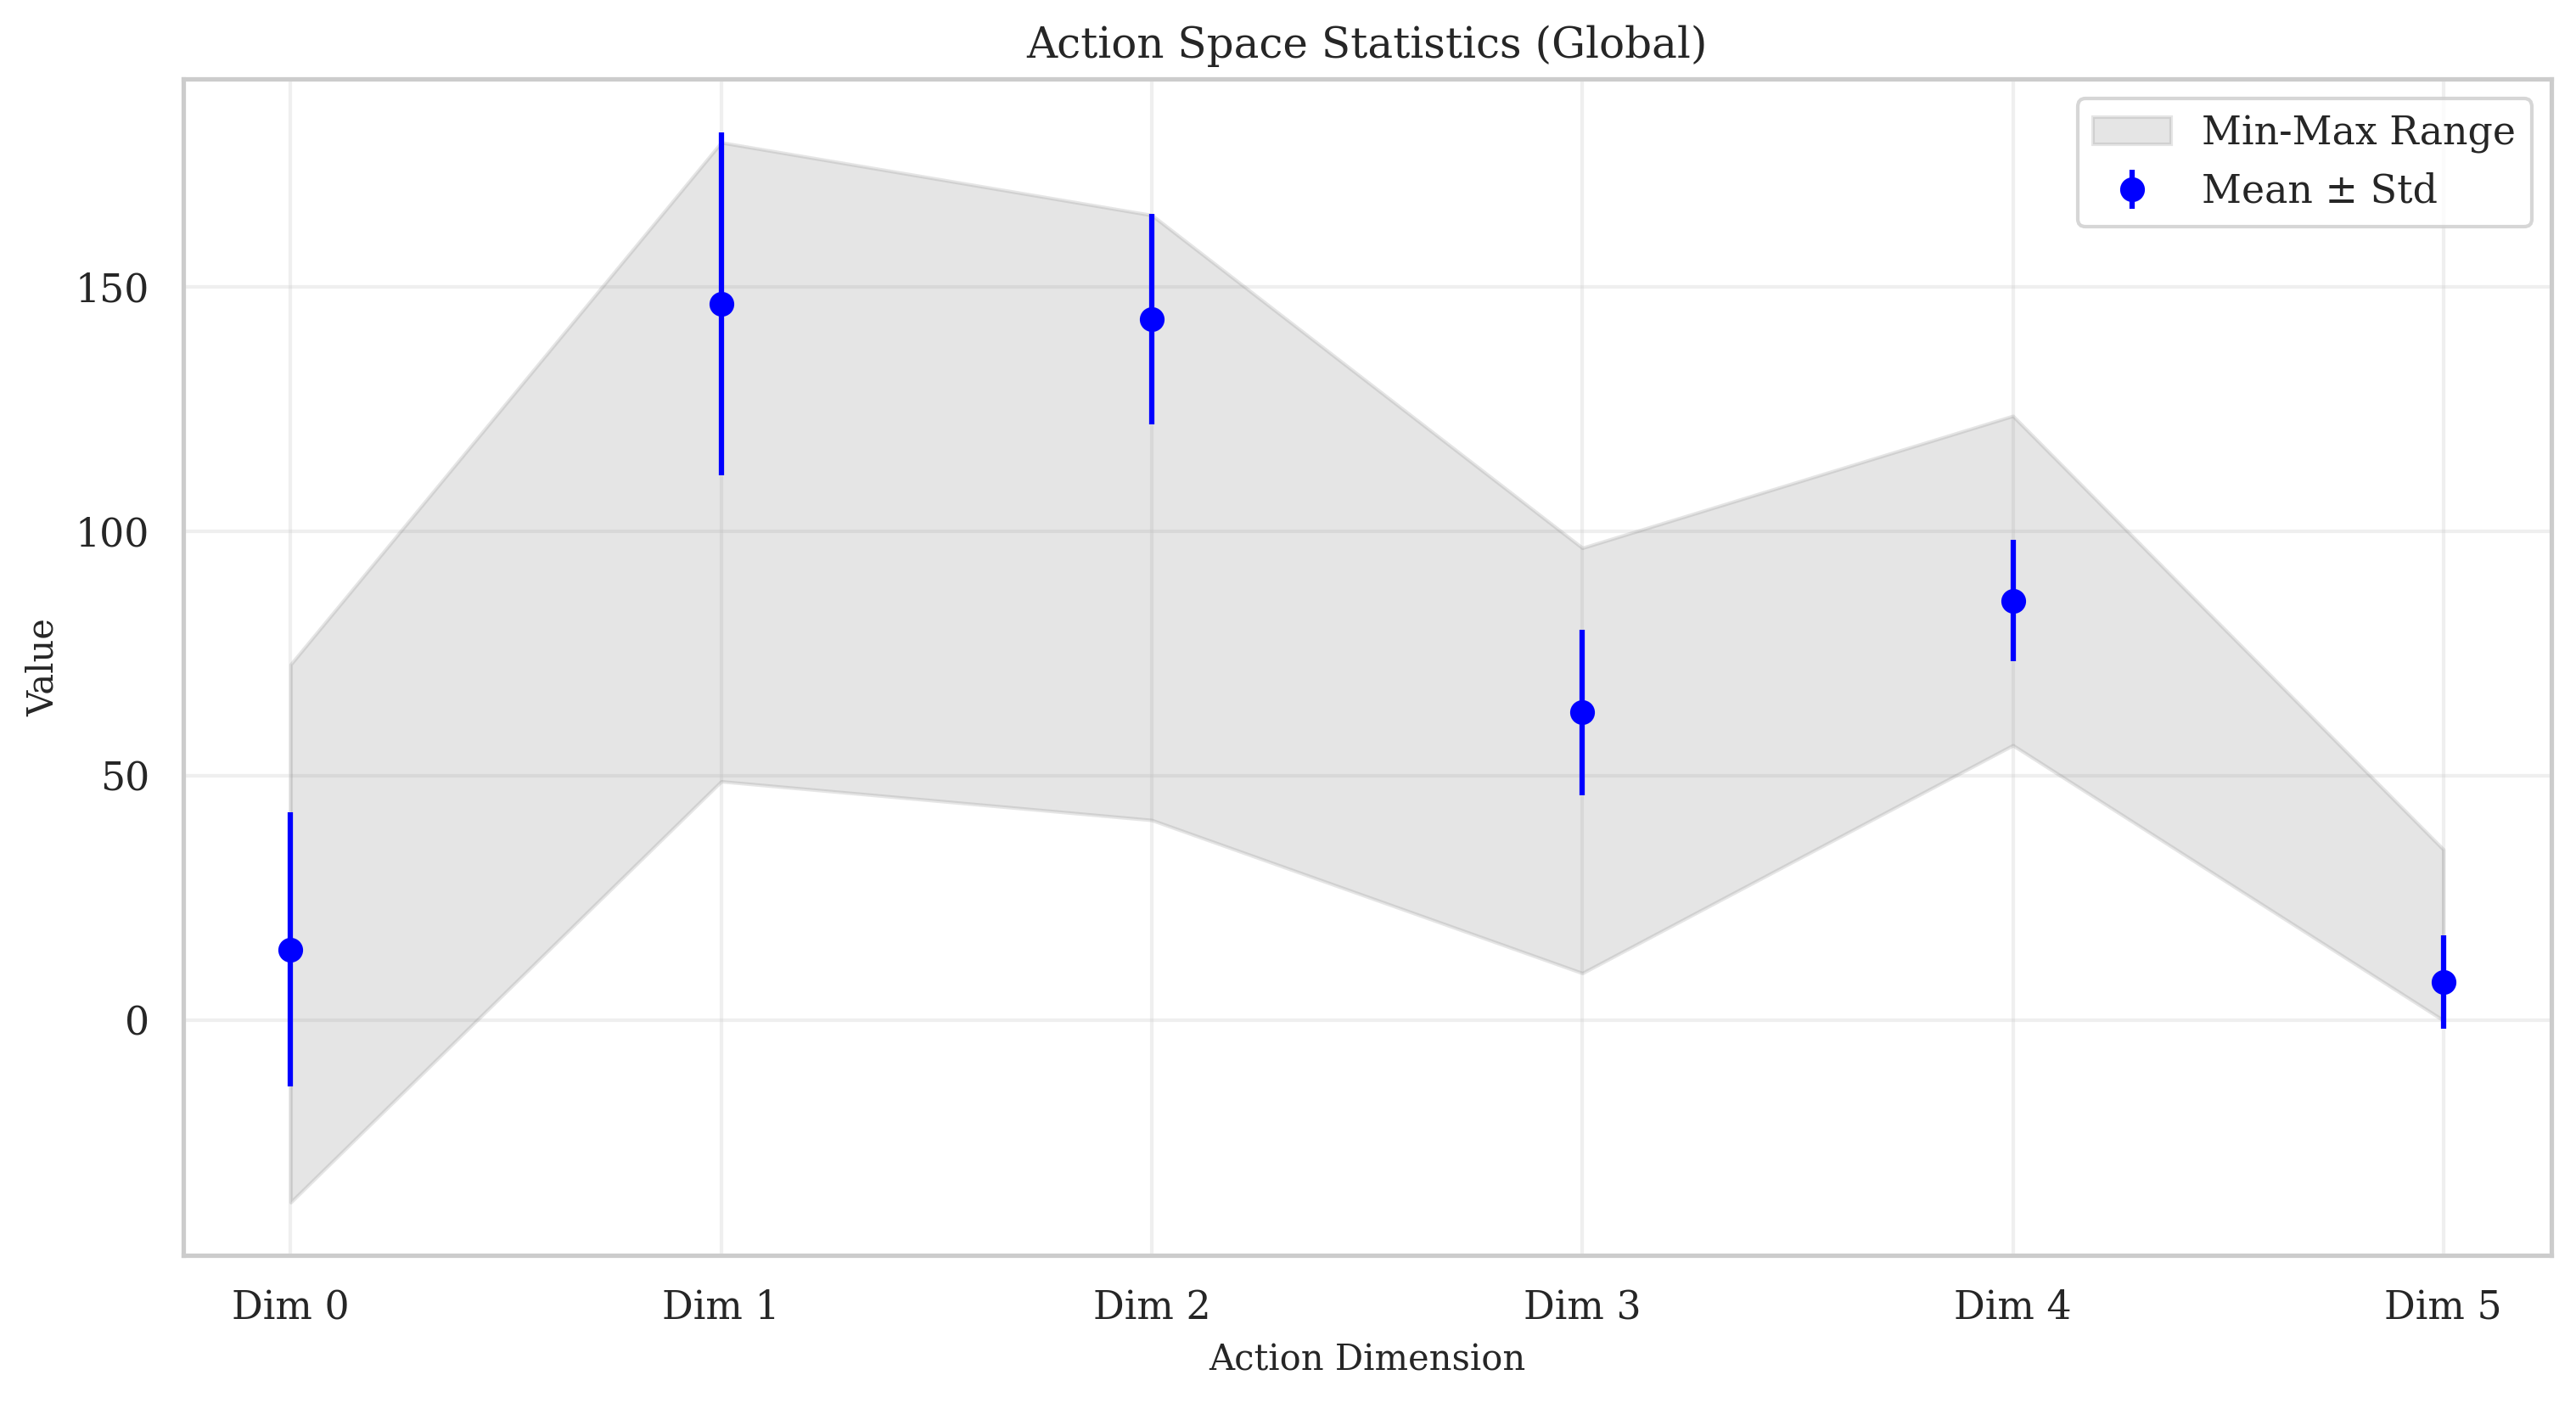

C:\Users\19142\AppData\Local\Temp\ipykernel_26656\1707604485.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions_tensor = torch.stack([torch.tensor(a) for a in actions])


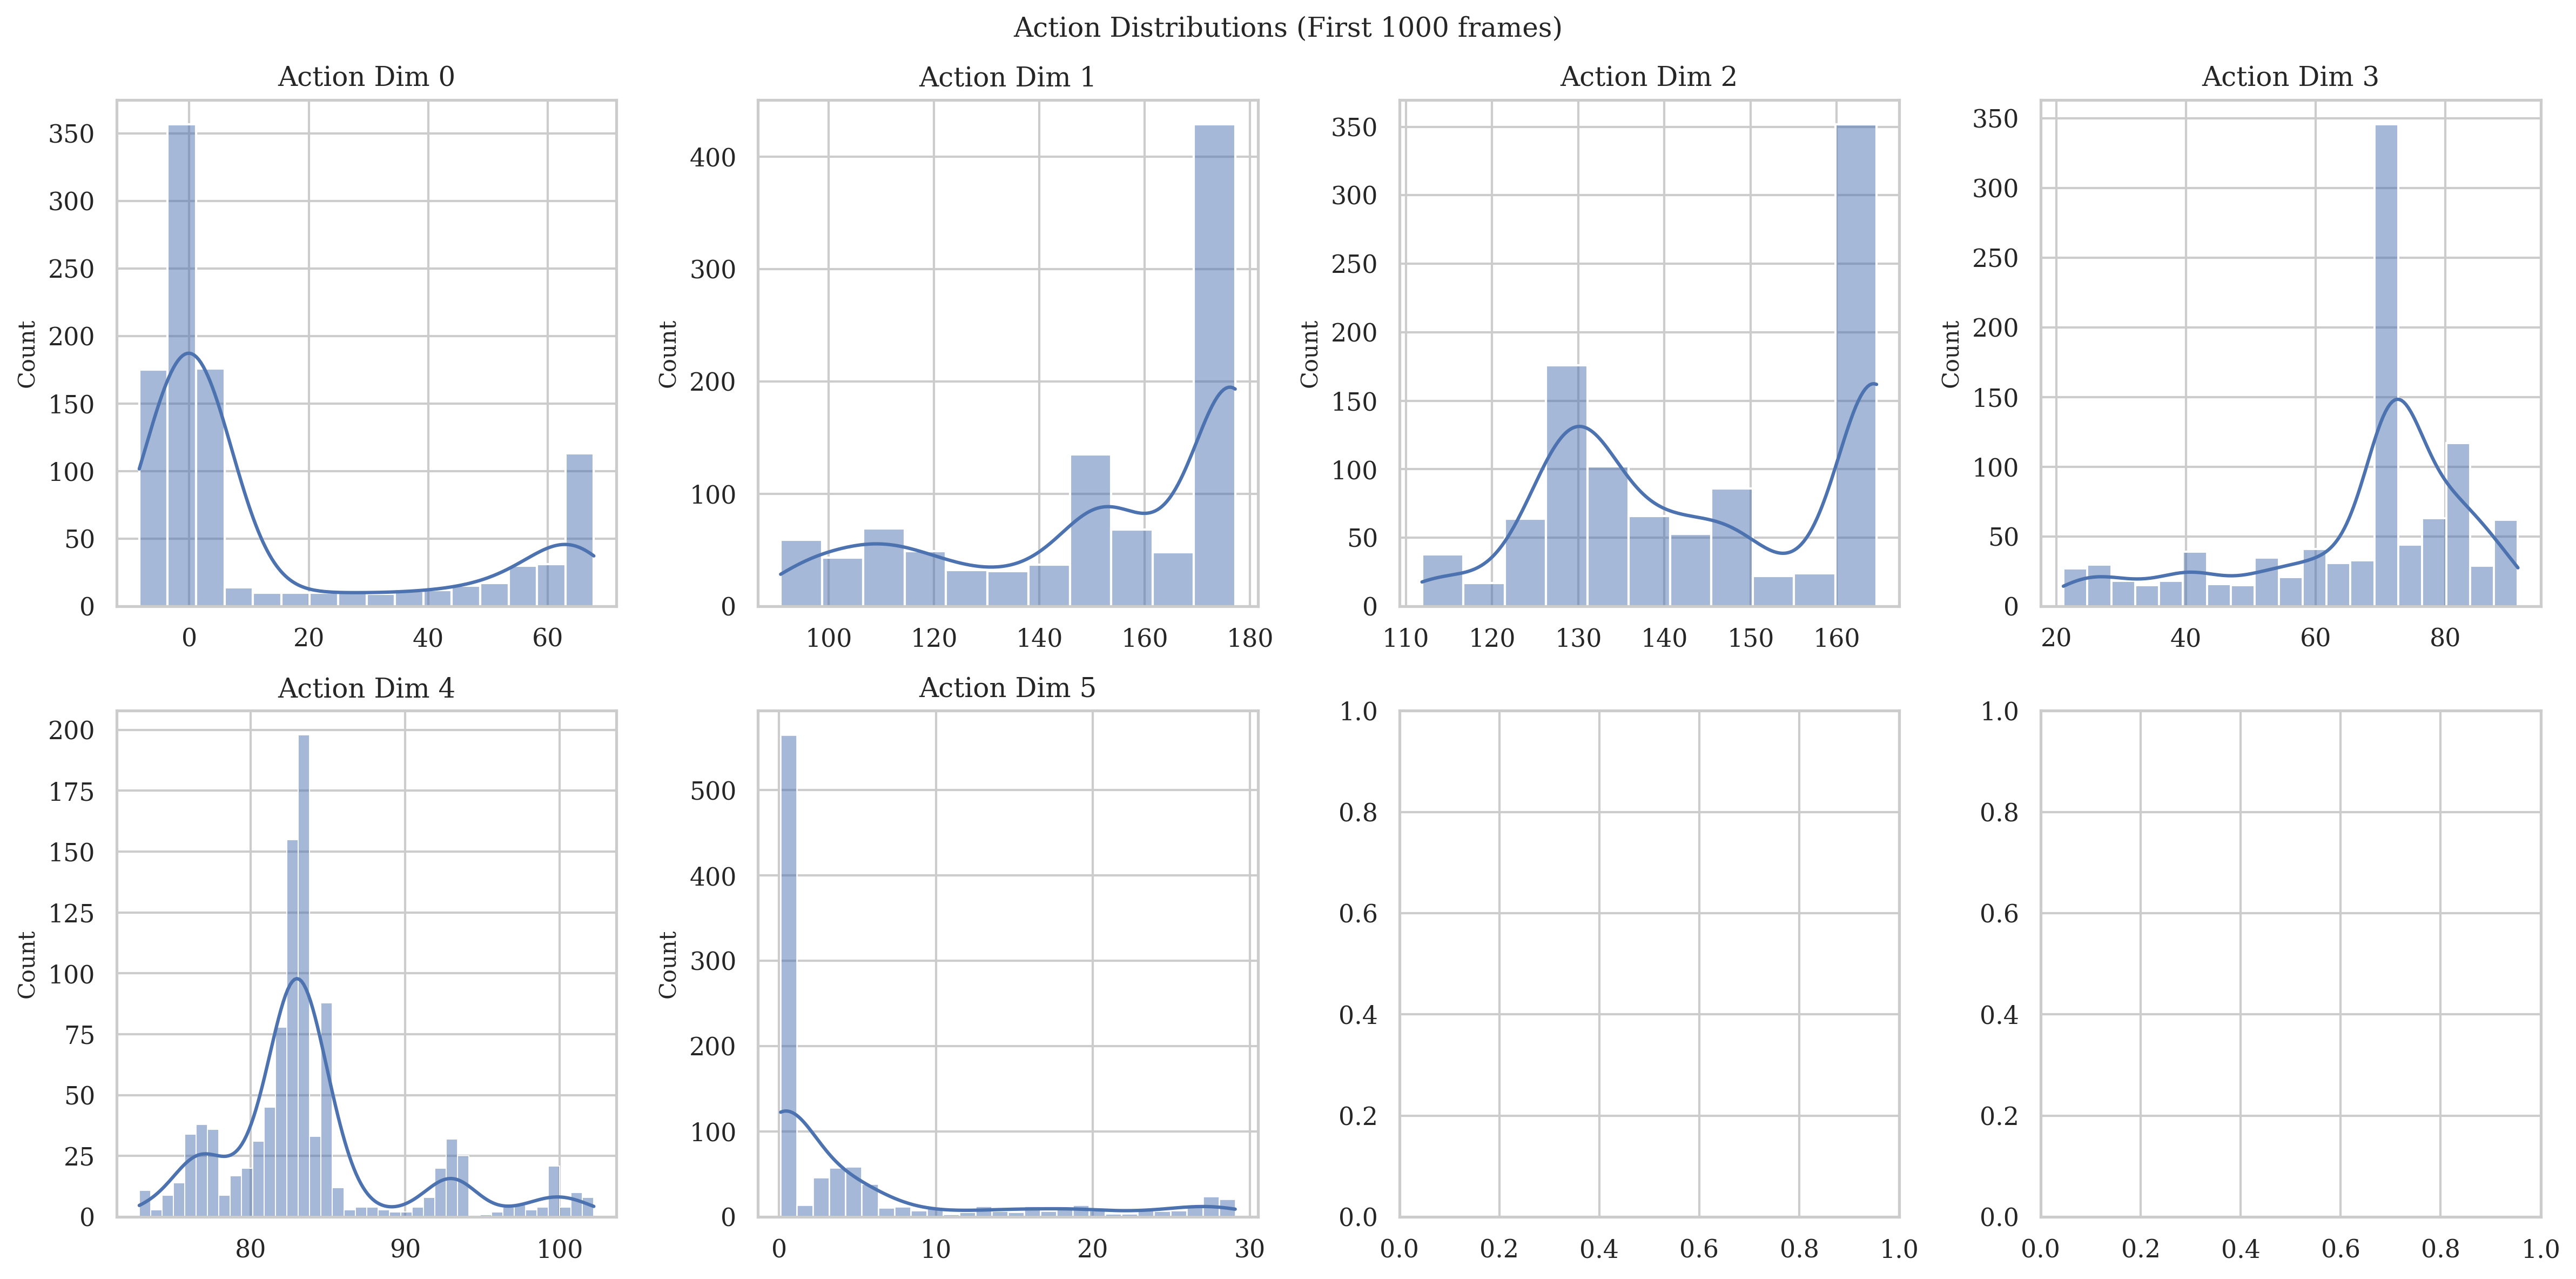

In [ ]:
import torch

# Sample part of the dataset for analysis (e.g., 10,000 frames or fewer)
# Use precomputed statistics from LeRobot for global distribution
stats = dataset.meta.stats['action']

# Plot action mean, std, and min–max ranges
action_dim = len(stats['mean'])
dims = [f"Dim {i}" for i in range(action_dim)]

plt.figure(figsize=(12, 6))
# Load real data to inspect distributions of each dimension (first 1000 frames)
plt.fill_between(dims, stats['min'], stats['max'], alpha=0.2, color='gray', label='Min-Max Range')
plt.errorbar(dims, stats['mean'], yerr=stats['std'], fmt='o', color='blue', label='Mean ± Std')

plt.title("Action Space Statistics (Global)")
plt.xlabel("Action Dimension")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



num_frames_to_load = min(1000, len(dataset))
actions = dataset.hf_dataset.select(range(num_frames_to_load))['action']
actions_tensor = torch.stack([torch.tensor(a) for a in actions])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Action Distributions (First 1000 frames)")
for i in range(action_dim):
    ax = axes[i // 4, i % 4]
    sns.histplot(actions_tensor[:, i], kde=True, ax=ax)
    ax.set_title(f"Action Dim {i}")
plt.tight_layout()
plt.show()

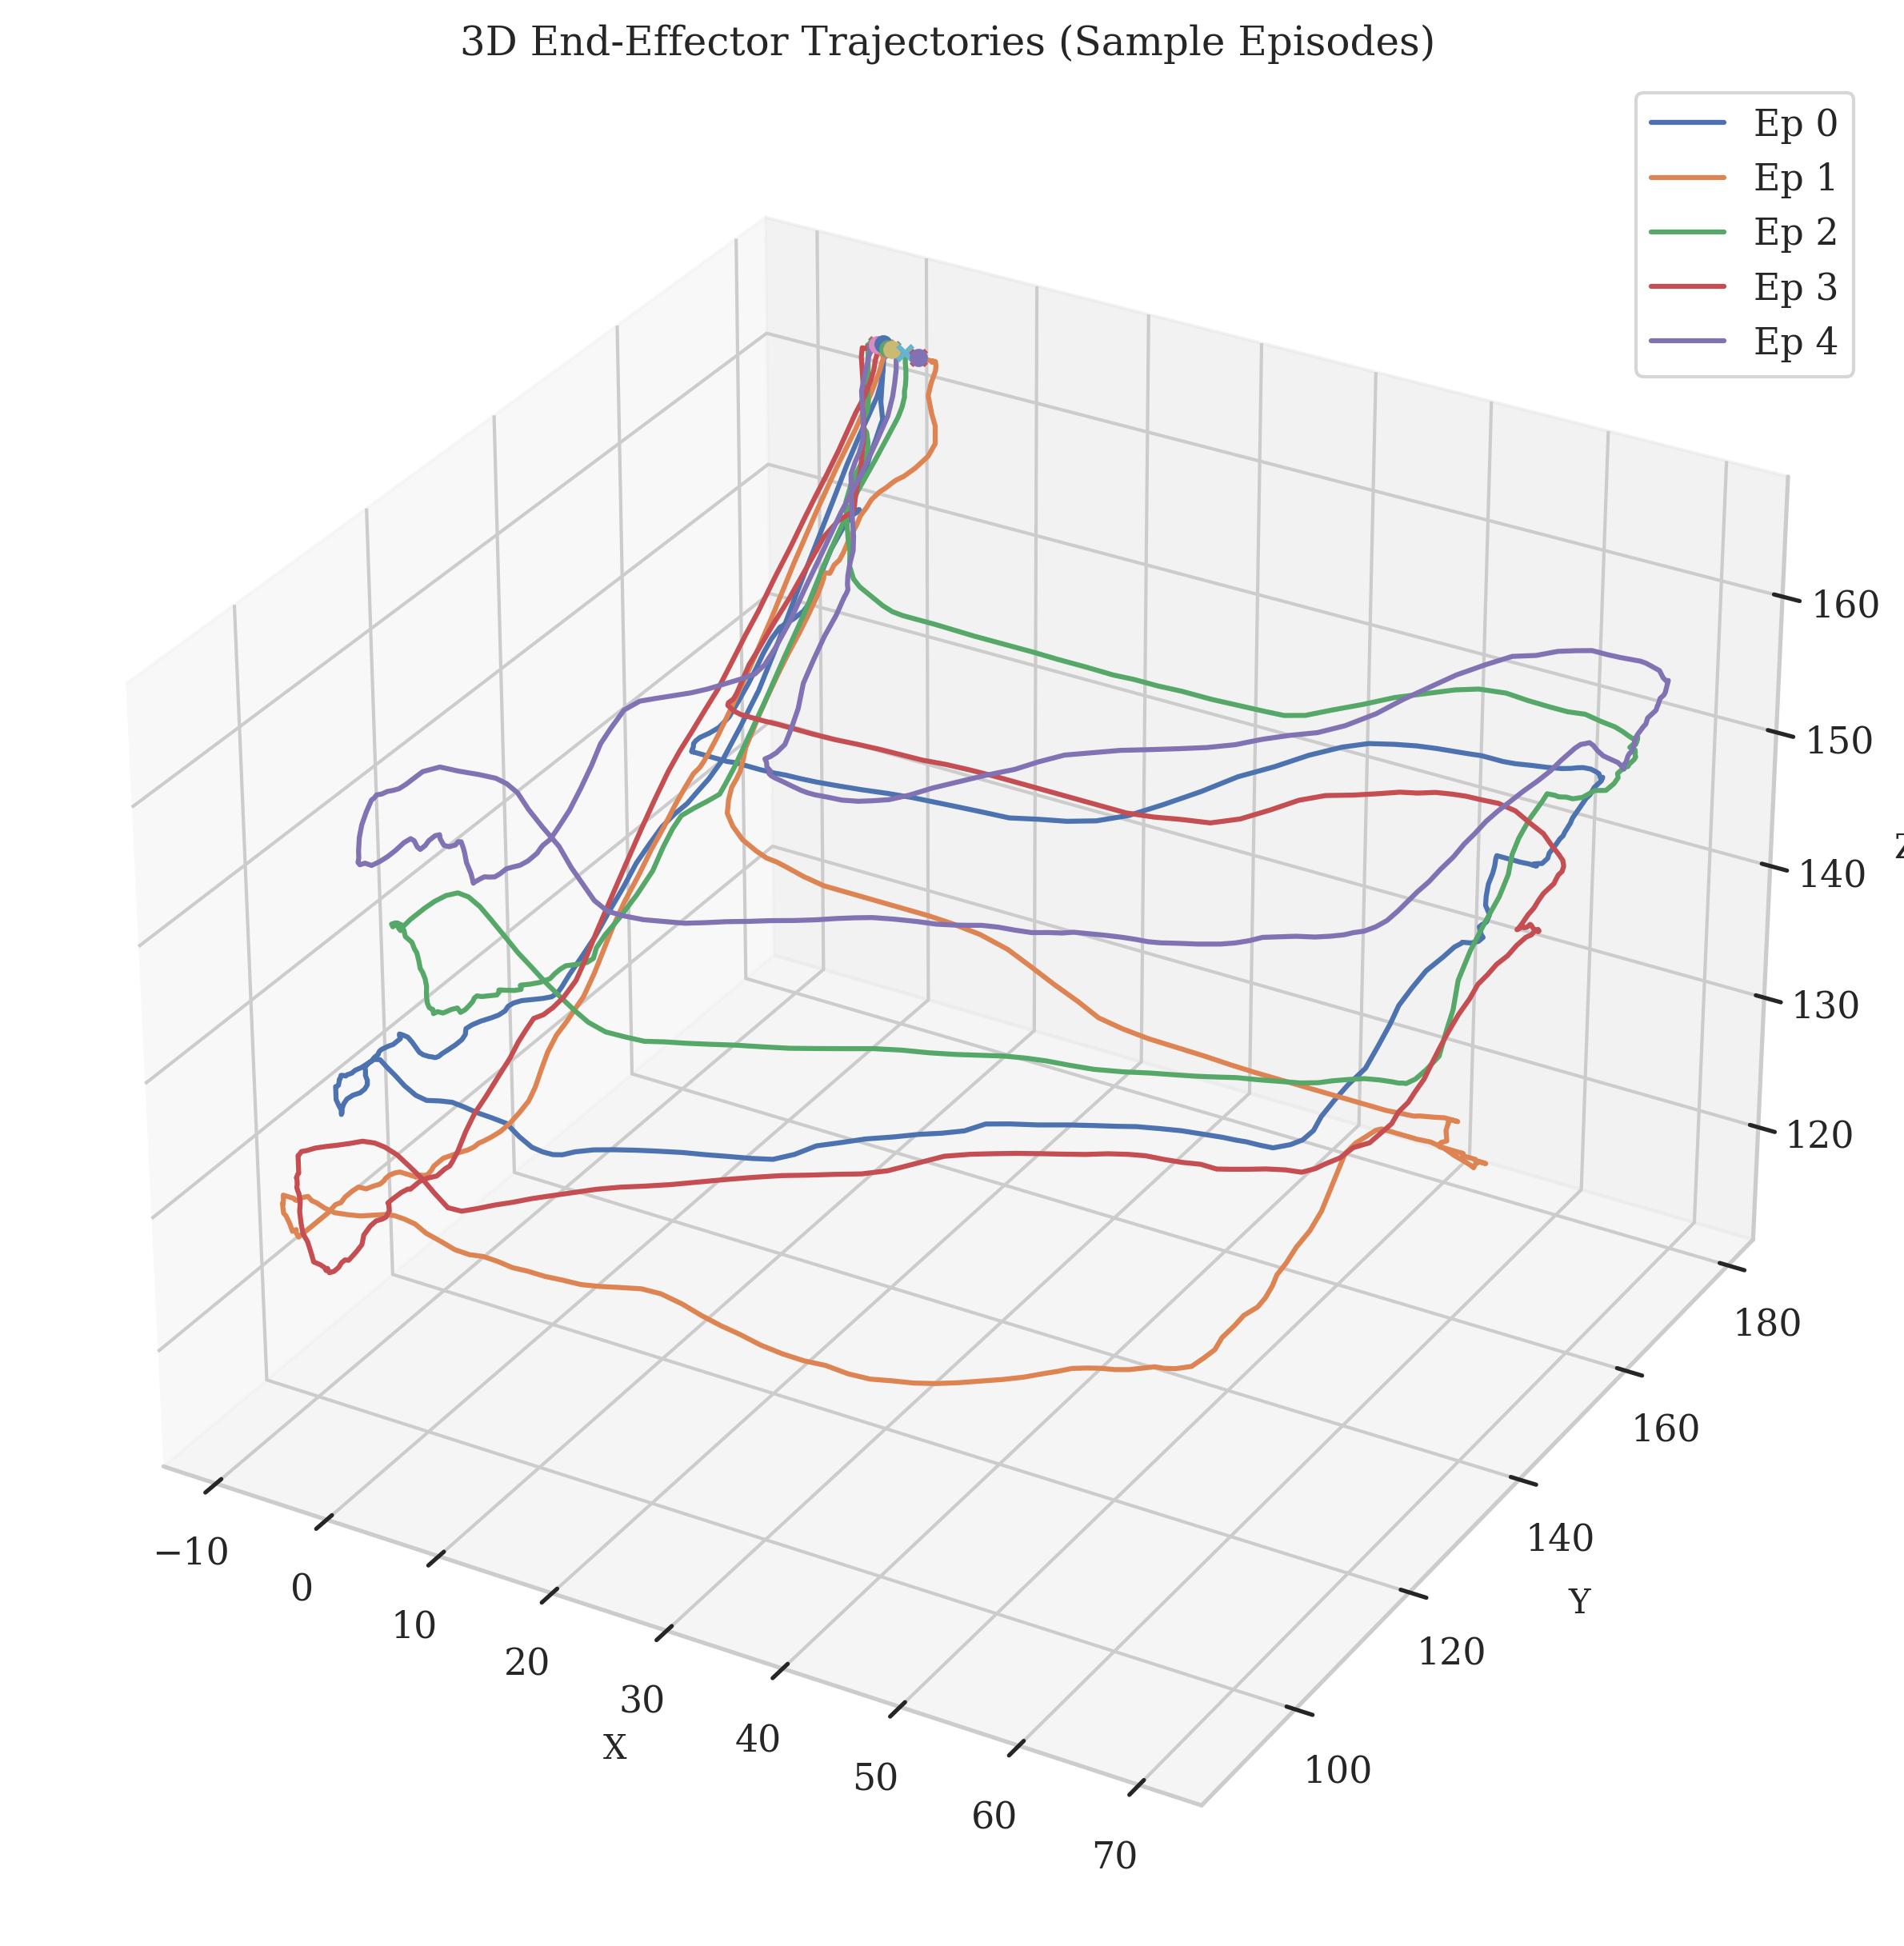

In [ ]:
# Visualize the 3D trajectories of the first 5 episodes (assuming the first 3 dimensions are XYZ)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(min(5, dataset.meta.total_episodes)):
    # Get the index range of this episode
    ep_meta = dataset.meta.episodes[i]
    start_idx = ep_meta['dataset_from_index']
    end_idx = ep_meta['dataset_to_index']
    
    # Get action or observation.state (depending on whether you want control commands or actual state)
    if 'observation.state' in dataset.features:
        key = 'observation.state' 
    else:
        key = 'action'  # If there is no state, use action to roughly visualize trends
        
    # Note: only load the data slice for this episode
    trajectory = dataset.hf_dataset.select(range(start_idx, end_idx))[key]
    traj_np = np.array(trajectory)
    
    ax.plot(traj_np[:, 0], traj_np[:, 1], traj_np[:, 2], label=f'Ep {i}')
    # Mark the start and end points
    ax.scatter(traj_np[0, 0], traj_np[0, 1], traj_np[0, 2], marker='o', s=20)
    ax.scatter(traj_np[-1, 0], traj_np[-1, 1], traj_np[-1, 2], marker='x', s=20)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D End-Effector Trajectories (Sample Episodes)")
plt.savefig("../outputs/3D_End-Effector_Trajectories.png", bbox_inches='tight')
ax.legend()
plt.show()

c:\Users\19142\.conda\envs\my_robotics\lib\site-packages\torchvision\io\_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


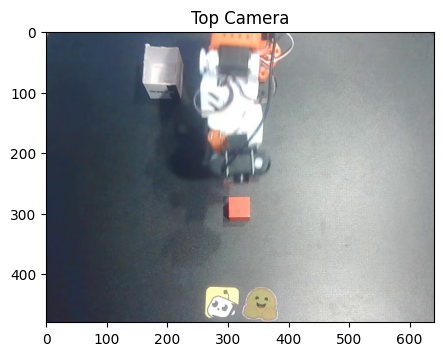

In [ ]:
item = dataset[100]

fig, ax = plt.subplots(figsize=(5, 5))
img_top = item['observation.images.top'].permute(1, 2, 0).numpy()
# img_wrist = item['observation.images.phone'].permute(1, 2, 0).numpy()

ax.imshow(img_top)
ax.set_title("Top Camera")
# ax[1].imshow(img_wrist)
# ax[1].set_title("Wrist Camera")
plt.show()

In [ ]:
print(item.keys())
print("Action Example:", item['action'])

dict_keys(['observation.images.top', 'observation.images.wrist', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task'])
Action Example: tensor([ -0.7910, 124.1016, 132.4512,  54.0527,  82.0020,   2.2364])
